In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
cn-02
/home/farshed.abdukhakimov/projects/sania


In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import urllib.request

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import torch.utils.data as data_utils
import torch.optim as optim

import torchvision
import torchvision.models as models

from sklearn.datasets import load_svmlight_file

import matplotlib.pyplot as plt

import experiments.loss_functions as lf
from experiments.utils import load_results, save_results
from experiments.datasets import get_MNIST, get_CIFAR10, get_FashionMNIST, get_CIFAR100

from SANIA import SANIA_AdagradSQR, SANIA_AdamSQR

from dotenv import load_dotenv
load_dotenv()

torch.set_default_dtype(torch.float64)

/home/farshed.abdukhakimov/miniconda3/envs/main/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
train_loader, test_loader = get_MNIST(train_batch_size=32, test_batch_size=512)

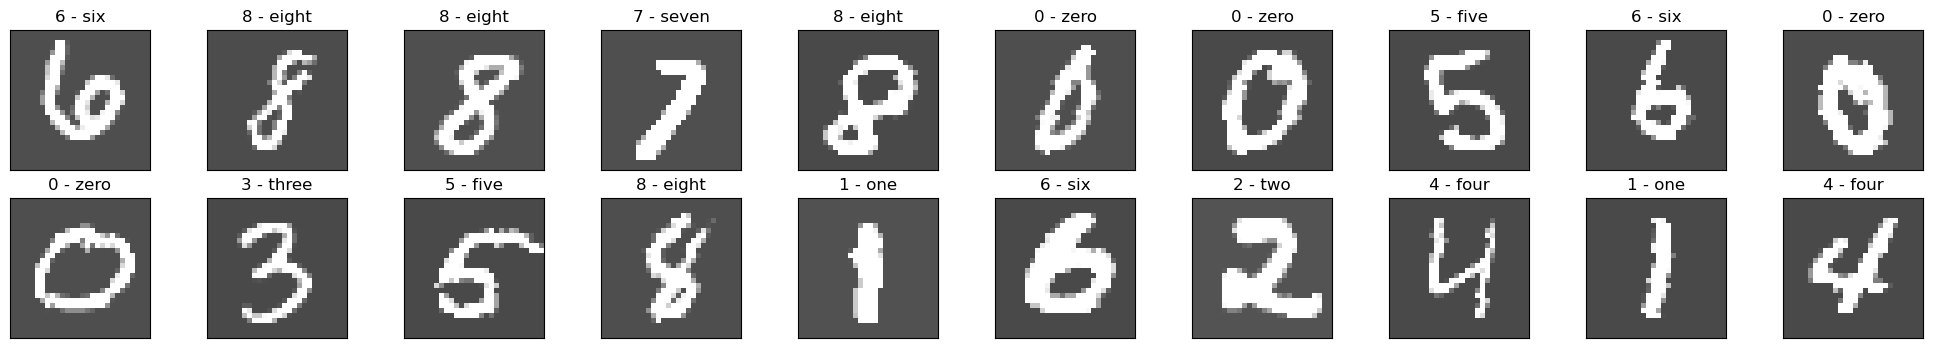

In [11]:
torch.manual_seed(0)

# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

# We iter the batch of images to display
dataiter = iter(train_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = next(dataiter) #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
    plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
    ax.set_title(train_loader.dataset.classes[labels[idx].item()])


In [20]:
class LeNet5(nn.Module):
    def __init__(self, num_classes: int = 2):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        return y
    
class LeNet5X(nn.Module):
    def __init__(self, num_classes: int = 2):
        super(LeNet5X, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(400, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(128, 84)
        self.relu5 = nn.ReLU()
        self.fc4 = nn.Linear(84, num_classes)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        y = self.fc4(y)
        return y


In [21]:
torch.random.manual_seed(0)
model = LeNet5X()
w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print ("Total parameters",d)  

Total parameters 149430


In [22]:
torch.random.manual_seed(0)
model = LeNet5()
w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print ("Total parameters",d)  

Total parameters 43746


In [23]:
torch.random.manual_seed(0)
model = models.resnet18(num_classes=10)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print(f"Total parameters: {d:,}")  

Total parameters: 11,181,642


In [24]:
def eval_model(model, criterion, test_loader, test_hist) -> None: 
    test_epoch_loss = 0.0
    total = 0
    correct = 0
    for i, (batch_data, batch_target) in enumerate(test_loader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        
        outputs = model(batch_data)
        loss = criterion(outputs, batch_target)
        test_epoch_loss += loss.item() * batch_data.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total += batch_target.size(0)
        batch_correct = (predicted == batch_target).sum().item()
        batch_accuracy = batch_correct / batch_target.size(0)
        correct += batch_correct
        
        test_hist["batch_loss"].append(loss.item())
        test_hist["batch_accuracy"].append(batch_accuracy)

    test_hist["epoch_loss"].append(test_epoch_loss / len(test_loader.sampler))
    test_hist["epoch_accuracy"].append(correct / total)

In [12]:
def train_loop(model: nn.Module, 
               opt: optim.Optimizer, 
               train_loader: DataLoader, 
               test_loader: DataLoader, 
               epochs: int, 
               seed: int = 0, 
               **optimizer_kwargs):

    torch.manual_seed(0)

    model = model(num_classes=len(train_loader.dataset.classes)).to(device)
    optimizer = opt(model.parameters(), **optimizer_kwargs)
    criterion = nn.CrossEntropyLoss()
    
    train_hist = {
        "epoch_loss": [],
        "batch_loss": [],
    }
    
    test_hist = {
        "epoch_accuracy": [],
        "batch_accuracy": [],
        "epoch_loss": [],
        "batch_loss": [],
    }
    
    torch.manual_seed(seed)
    

    for epoch in range(epochs):
        
        print(f"Epoch: [{epoch}]")
        
        model.eval()
        with torch.inference_mode():
            eval_model(model, criterion, test_loader, test_hist)
            print(f"Test accuracy: {test_hist['epoch_accuracy'][-1]}")
        
        
        train_epoch_loss = 0.0
        model.train()
        for i, (batch_data, batch_target) in enumerate(train_loader): 
            
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)
            
            optimizer.zero_grad()

            outputs = model(batch_data)
            def closure():
                return criterion(outputs, batch_target)
            loss = closure()
            train_epoch_loss += loss.item() * batch_data.size(0)

            loss.backward()
            optimizer.step(closure=closure)
            
            train_hist["batch_loss"].append(loss.item())
            
        train_epoch_loss = train_epoch_loss / len(train_loader.sampler)
        train_hist["epoch_loss"].append(train_epoch_loss)
        print(f"Train loss: {train_epoch_loss:.4f}")

    return {
        "train_hist": train_hist,
        "test_hist": test_hist,
        "model_state_dict": model.state_dict()
    }


In [19]:
models.resnet50()._get_name()

'ResNet'

In [ ]:
hist = train_loop(model=models.resnet50, 
                opt=optim.Adam, 
                train_loader=train_loader, 
                test_loader=test_loader, 
                epochs=10,
                lr=0.001,
                # eps=0.5,
                )

In [143]:
# def dynamic_sliding_window(x):
def dsw(list_, max_window_size=4):
    
    start = 0
    window_size = 1
    results = []
    mean = lambda x: sum(x) / len(x)

    while True:
        
        if start+window_size > len(list_):
            if start == len(list_): break
            # print(list_[start:])
            results.append(round(mean(list_[start:]), 6))
            break
        else:
            # print(list_[start:start+window_size])
            results.append(round(mean(list_[start:start+window_size]), 6))
        start = start+window_size
        
        if window_size < max_window_size:
            window_size += 1
            


    return results

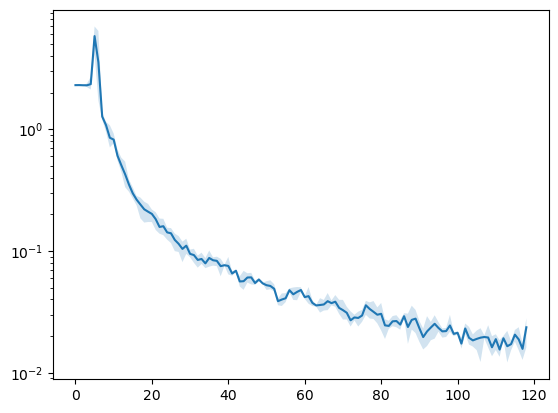

In [146]:
train_loss = [dsw(x["train_hist"]["batch_loss"], 50) for x in all_res]

mean_line = np.mean(train_loss, axis=0)
max_line = np.max(train_loss, axis=0)
min_line = np.min(train_loss, axis=0)

x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])

plt.fill_between(x, max_line, min_line, alpha=0.2) 
plt.semilogy(x, mean_line)

# plt.ylim(bottom=0.9, top=1.0)